In [62]:
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import yfinance as yf
from finta import TA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from ta import add_all_ta_features

In [63]:
WINDOW = 16 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'AAPL'      # Symbol of the desired stock
# INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'CCI', 'VORTEX']
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'VORTEX']

In [64]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-03-23 04:00:00-04:00,56.220000,56.220000,55.500000,55.600000,55.600000,0
2020-03-23 05:00:00-04:00,55.550000,56.095000,55.370000,55.700000,55.700000,0
2020-03-23 06:00:00-04:00,56.032500,56.437500,55.937500,56.247500,56.247500,0
2020-03-23 07:00:00-04:00,56.132500,56.750000,56.042500,56.595000,56.595000,0
2020-03-23 08:00:00-04:00,56.550000,58.197500,55.625000,57.812500,57.812500,0
...,...,...,...,...,...,...
2021-03-22 13:30:00-04:00,123.090103,123.720001,123.080002,123.542000,123.542000,9430925
2021-03-22 14:30:00-04:00,123.544998,123.870003,123.275002,123.345001,123.345001,11354023
2021-03-22 15:30:00-04:00,123.339996,123.599998,123.019997,123.370003,123.370003,10684835


In [65]:
data.head(9)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-03-23 04:00:00-04:00,56.220000,56.220000,55.500000,55.600000,55.600000,0
2020-03-23 05:00:00-04:00,55.550000,56.095000,55.370000,55.700000,55.700000,0
2020-03-23 06:00:00-04:00,56.032500,56.437500,55.937500,56.247500,56.247500,0
2020-03-23 07:00:00-04:00,56.132500,56.750000,56.042500,56.595000,56.595000,0
2020-03-23 08:00:00-04:00,56.550000,58.197500,55.625000,57.812500,57.812500,0
2020-03-23 09:00:00-04:00,57.837500,59.525000,56.887500,57.020000,57.020000,0
2020-03-23 09:30:00-04:00,56.299999,56.750000,54.823750,55.450001,55.450001,21473989
2020-03-23 10:30:00-04:00,55.465000,55.889999,53.412498,53.767502,53.767502,11306818
2020-03-23 11:30:00-04:00,53.762501,55.097500,53.152500,54.803925,54.803925,11355189


In [66]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Datetime,,,,,,
2020-03-23 04:00:00-04:00,56.220000,56.220000,55.500000,55.600000,55.600000,0
2020-03-23 05:00:00-04:00,55.550000,56.095000,55.370000,55.700000,55.700000,0
2020-03-23 06:00:00-04:00,56.032500,56.437500,55.937500,56.247500,56.247500,0
2020-03-23 07:00:00-04:00,56.132500,56.750000,56.042500,56.595000,56.595000,0
2020-03-23 08:00:00-04:00,56.550000,58.197500,55.625000,57.812500,57.812500,0
2020-03-23 09:00:00-04:00,57.837500,59.525000,56.887500,57.020000,57.020000,0
2020-03-23 09:30:00-04:00,56.299999,56.750000,54.823750,55.450001,55.450001,21473989
2020-03-23 10:30:00-04:00,55.465000,55.889999,53.412498,53.767502,53.767502,11306818
2020-03-23 11:30:00-04:00,53.762501,55.097500,53.152500,54.803925,54.803925,11355189


<AxesSubplot:xlabel='Datetime'>

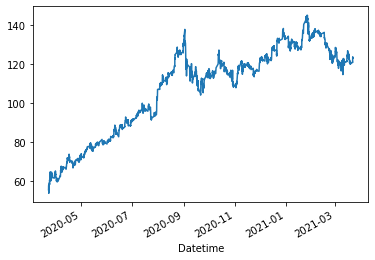

In [67]:
data['close'].plot()

In [68]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
    data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    # del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [69]:
data

,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-23 04:00:00-04:00,55.600000,0,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,-2419.844555,...,-86.111111,0.000000,55.600000,0.000000,0.000000,0.000000,0.000000,-47.866311,0.000000,0.000000
2020-03-23 05:00:00-04:00,55.700000,0,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,-61.176471,0.000000,55.643170,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856
2020-03-23 06:00:00-04:00,56.247500,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,-17.798595,0.000000,55.899195,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568
2020-03-23 07:00:00-04:00,56.595000,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,-11.231884,0.000000,56.195363,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568
2020-03-23 08:00:00-04:00,57.812500,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,-13.616269,0.000000,56.834542,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 13:30:00-04:00,123.542000,9430925,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,572.870640,...,-1.943993,1.853018,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841
2021-03-22 14:30:00-04:00,123.345001,11354023,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,16441.600479,...,-13.392887,2.216141,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527
2021-03-22 15:30:00-04:00,123.370003,10684835,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,-15939.217126,...,-12.755093,2.310367,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494


In [70]:
data.columns

Index(['close', 'volume', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_mfi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend

In [71]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.5:
        return 1
    if row['close_shift'] -row['close']< -1.5:
        return -1
    else:
        return 0

In [72]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-23 04:00:00-04:00,55.600000,0,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,-2419.844555,...,0.000000,55.600000,0.000000,0.000000,0.000000,0.000000,-47.866311,0.000000,0.000000,56.8750
2020-03-23 05:00:00-04:00,55.700000,0,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,55.643170,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856,58.4475
2020-03-23 06:00:00-04:00,56.247500,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,55.899195,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568,58.5500
2020-03-23 07:00:00-04:00,56.595000,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,56.195363,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568,59.2225
2020-03-23 08:00:00-04:00,57.812500,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,0.000000,56.834542,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317,58.3075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 13:30:00-04:00,123.542000,9430925,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,572.870640,...,1.853018,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841,NaN
2021-03-22 14:30:00-04:00,123.345001,11354023,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,16441.600479,...,2.216141,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527,NaN
2021-03-22 15:30:00-04:00,123.370003,10684835,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,-15939.217126,...,2.310367,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494,NaN


In [73]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,close_shift,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-23 04:00:00-04:00,55.600000,0,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,-2419.844555,...,55.600000,0.000000,0.000000,0.000000,0.000000,-47.866311,0.000000,0.000000,56.8750,0
2020-03-23 05:00:00-04:00,55.700000,0,-0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,55.643170,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856,58.4475,1
2020-03-23 06:00:00-04:00,56.247500,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,55.899195,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568,58.5500,1
2020-03-23 07:00:00-04:00,56.595000,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,56.195363,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568,59.2225,1
2020-03-23 08:00:00-04:00,57.812500,0,0.000000e+00,0,0.000000,0.000000e+00,50.000000,0.000000,0.000000,0.000000,...,56.834542,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317,58.3075,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 13:30:00-04:00,123.542000,9430925,6.814015e+08,-295204416,0.073995,3.995690e+06,100.000000,-0.033912,4.115061,572.870640,...,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841,NaN,0
2021-03-22 14:30:00-04:00,123.345001,11354023,6.727190e+08,-306558439,-0.022353,3.105345e+06,100.000000,0.903980,3.579881,16441.600479,...,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527,NaN,0
2021-03-22 15:30:00-04:00,123.370003,10684835,6.749298e+08,-295873604,0.039436,2.699886e+06,88.424942,-1.424946,2.864906,-15939.217126,...,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494,NaN,0


In [74]:
# Class divide
data['class_column'].value_counts()

 0    2289
 1    1106
-1     789
Name: class_column, dtype: int64

In [75]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()

In [76]:
data['class_column'].value_counts()


 0    2289
 1    1106
-1     789
Name: class_column, dtype: int64

In [77]:
def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

def init_classifiers():
    classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
    classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best')
    classifiers['RandomForestClassifier 1'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='gini')
    classifiers['RandomForestClassifier 2'] = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=0,criterion='gini')
    classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
    classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
    classifiers['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.5)

In [78]:

features = [x for x in data.columns if x not in ['class_column']]
num_step = 100 #  (len(data) / num_train  =  number of train-test sets
len_set = 200 # Length of each train-test set

score = defaultdict(list)
step_headers = []
i = 0

while True:
    df = data.iloc[i * num_step : (i * num_step) + len_set]
    print("step: ", i * num_step, (i * num_step) + len_set)
    print(df['class_column'].value_counts())
    if len(df) < len_set:
        break


    step_headers.append(f'<{i * num_step, (i * num_step) + len_set}>')
    y = df['class_column']
    x = df[features]
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.33, shuffle=False)
    classifiers = dict()
    init_classifiers()
    predictions= dict()
    for k,v in classifiers.items():
        print("Calculate: ", k)
        train_model(v,x_train,y_train)
        predictions[k] = v.predict(x_test)
        score[k].append(accuracy_score(y_test.values, predictions[k]))

    i += 1

step:  0 200
 0    90
 1    76
-1    34
Name: class_column, dtype: int64
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  RandomForestClassifier 1
Calculate:  RandomForestClassifier 2
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  GradientBoostingClassifier 3
step:  100 300
 0    120
 1     55
-1     25
Name: class_column, dtype: int64
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  RandomForestClassifier 1
Calculate:  RandomForestClassifier 2
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2
Calculate:  GradientBoostingClassifier 3
step:  200 400
 0    133
 1     44
-1     23
Name: class_column, dtype: int64
Calculate:  DecisionTreeClassifier 1
Calculate:  DecisionTreeClassifier 2
Calculate:  RandomForestClassifier 1
Calculate:  RandomForestClassifier 2
Calculate:  GradientBoostingClassifier 1
Calculate:  GradientBoostingClassifier 2

In [79]:
# print(score['DecisionTreeClassifier 1'])
# print(score['DecisionTreeClassifier 2'])

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
# print(tabulate(score_df, headers, tablefmt="psql"))
headers2 = ["Classifier type",] + step_headers
score_df = pd.DataFrame(score.items(), columns=headers)
accuracy_df = pd.DataFrame(score_df['Accuracy'].tolist(), index= score_df.index, columns=step_headers)
score_df = score_df.drop('Accuracy', 1)
f_out = pd.merge(score_df, accuracy_df, how='left', left_index=True, right_index=True)
f_out['mean'] = f_out.mean(axis=1)
headers2 = headers2 + ['mean']
print(tabulate(f_out,headers2 , tablefmt="psql"))

+----+------------------------------+--------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+
|    | Classifier type              |   <(0, 200)> |   <(100, 300)> |   <(200, 400)> |   <(300, 500)> |   <(400, 600)> |   <(500, 700)> |   <(600, 800)> |   <(700, 900)> |   <(800, 1000)> |   <(900, 1100)> |   <